<div>
    <h2> Network Intrusion Detection using Linear Models, GBDT Ensembles and Deep Learning - A comparative study using state-of-the-art tools and libraries </h2>
    <p> In this study, we use the <a href='https://www.unb.ca/cic/datasets/nsl.html'>NSL KDD dataset</a> to predict the probability of occurence of 23 different classes of attacks on a network. Here, we use three different categories of models - Linear Models including Logistic Regression and Stochastic Gradient Descent (SGD) classifier; Gradient Boosting Decision Tree emsembles including LightGBM (LGBM) and XGBoost; and a Deep Neural Network (DNN) classifier. We also train a stacked model consisting of all these models as base learners. Finally, we compare the performances of all the models for Network Intrusion Detection using the NSL-KDD dataset and draw useful conclusions.</p>
</div>

In [16]:
# import required packages

import pandas as pd 
import numpy as np
import math, os, re, gc, time, warnings
from tqdm import tqdm

from entropy_calculator import ddosDetection
from scapy.all import *
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM,  Embedding




import tensorflow as tf


%matplotlib inline

# settings
os.environ['OMP_NUM_THREADS'] = '4'
start_time = time.time()


warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 100)

In [17]:
data = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')

data=data.rename(columns={' Source IP':'Source IP'})
data=data.rename(columns={' Destination IP':'Destination IP'})
data=data.rename(columns={' Source Port':'Source Port'})
data=data.rename(columns={' Destination Port':'Destination Port'})
data=data.rename(columns={' Protocol':'Protocol'})


data=data.rename(columns={' Average Packet Size':'LEN'})

#data=data.columns.str.replace(' ','')

data['Source IP']=data['Source IP']+'-'+data['Destination IP']

data['Source Port']=data['Protocol'].apply(str)+'-'+data['Source Port'].apply(str)+'-'+data['Destination Port'].apply(str)

data

#기존 오브제특 형태인 ip address 를 제거, 나머지 데이터 라벨 인코더
encoder = LabelEncoder()

# 기존 포트 번호를 라벨링으로 생성
en_col=['Source Port' , 'Destination Port', 'Protocol','Source IP', 'Destination IP', 'LEN']
for i in en_col:
    data[i] = encoder.fit_transform(data[i])
    

TH=0.5
    

def IDS(a,b,c):
    
    aa=np.float_(a.sumEntropy_history[-1:])
    bb=np.float_(b.sumEntropy_history[-1:])
    cc=np.float_(c.sumEntropy_history[-1:])
    
    a_mean=np.mean(a.sumEntropy_history)
    b_mean=np.mean(b.sumEntropy_history)
    c_mean=np.mean(c.sumEntropy_history)
    
    a_max=a_mean+TH
    b_max=b_mean+TH
    c_max=c_mean+TH
    
    a_min=(0 if a_mean-TH<=0 else a_mean-TH)
    b_min=(0 if b_mean-TH<=0 else b_mean-TH)
    c_min=(0 if c_mean-TH<=0 else c_mean-TH)

    #print(a_min,aa,a_max)
    if (a_min>aa) or (aa>a_max):
        #print('1')
        if (b_min>bb) or (bb>b_max):
            print('2')
            if (c_min>cc) or (cc>c_max):
                print('3')
                return 1
    else:
        return 0

entropy_SP_store=[]
#entropy_DP_store=[]
entropy_SIP_store=[]
#entropy_DIP_store=[]
entropy_LEN_store=[]

SIP = ddosDetection()
#DIP = ddosDetection()
SP = ddosDetection()
#DP = ddosDetection()
LEN=ddosDetection()

data["SIP"] = np.nan
#data["DIP"] = np.nan
data["SP"] = np.nan
#data["DP"] = np.nan
data["LEN"] = np.nan


Win_size=100

for i in tqdm(range(0,len(data))):
    SIP.addinfo(data['Source IP'][i])
    #DIP.addinfo(data['Destination IP'][i])
    SP.addinfo(data['Source Port'][i])
    #DP.addinfo(data['Destination Port'][i])
    LEN.addinfo(data['LEN'][i])
    
    #print(data['Source IP'][i])

    if i % Win_size == 0:
        SIP.calculateEntropy()
        #DIP.calculateEntropy()
        SP.calculateEntropy()
        #DP.calculateEntropy()
        LEN.calculateEntropy()
        
        
        entropy_SIP_store.extend(SIP.sumEntropy_history[-1:])
        #entropy_DIP_store.extend(DIP.sumEntropy_history[-1:]) 
        entropy_SP_store.extend(SP.sumEntropy_history[-1:])
        #entropy_DP_store.extend(DP.sumEntropy_history[-1:]) 
        entropy_LEN_store.extend(LEN.sumEntropy_history[-1:]) 
        
        #data.append(SP.sumEntropy_history[-1:])
        #data.append(DP.sumEntropy_history[-1:]) 
        #data.append(LEN.sumEntropy_history[-1:]) 
        
        if IDS(LEN,SP,SIP)==1:
            print(i)

SIP=pd.DataFrame()
SIP['SIP']=entropy_SP_store

#DIP=pd.DataFrame()
#DIP['DIP']=entropy_DP_store

SP=pd.DataFrame()
SP['SP']=entropy_SP_store

#DP=pd.DataFrame()
#DP['DP']=entropy_DP_store

LEN=pd.DataFrame()
LEN['LEN']=entropy_LEN_store


SIP.to_csv('mer_normal_SIP.csv',index=False)
SP.to_csv('mer_normal_SP.csv',index=False)
LEN.to_csv('mer_normal_LEN.csv',index=False)

In [18]:
SIP = pd.read_csv('mer_normal_SIP.csv')
SP = pd.read_csv('mer_normal_SP.csv')


In [19]:
for s in range(1, 4):
    SIP['shift_{}'.format(s)] = SIP['SIP'].shift(s)
    #DIP['shift_{}'.format(s)] = DIP['DIP'].shift(s)
    SP['shift_{}'.format(s)] = SP['SP'].shift(s)
    #DP['shift_{}'.format(s)] = DP['DP'].shift(s)

SIP=SIP.fillna(method='bfill') # 빈 데이터 채우기   
SP=SP.fillna(method='bfill') # 빈 데이터 채우기   

SIP['max']=SIP.max(axis=1)
SIP['min']=SIP.min(axis=1)


SP['max']=SP.max(axis=1)
SP['min']=SP.min(axis=1)


plt.figure(figsize=(8,4))

plt_len1=1000
plt_len2=1200

a=LEN['LEN'][plt_len1:plt_len2]
b=LEN['max'][plt_len1:plt_len2]
c=LEN['min'][plt_len1:plt_len2]

x=list(range(len(LEN_shift)))
x_len=x[plt_len1:plt_len2]

plt.plot(a, label='law')
plt.plot(b, label='max')
plt.plot(c, label='min')

# 영역 채우기
plt.fill_between(x_len, b, c, color='gray', alpha=0.5)

# 범례 표시
plt.legend()
plt.show()

In [20]:
SIP['dif']=SIP['max']-SIP['min']
SIP_dif_max=SIP['dif'].max()
SIP['EN_max']=(SIP['SIP']+SIP['shift_1']+SIP['shift_2']+SIP['shift_3'])/4+SIP_dif_max*(SIP['dif']/SIP_dif_max)+SIP['dif']
SIP['EN_Min']=(SIP['SIP']+SIP['shift_1']+SIP['shift_2']+SIP['shift_3'])/4-SIP_dif_max*(SIP['dif']/SIP_dif_max)-+SIP['dif']
#SIP[SIP['EN_min']<1]=1



SP['dif']=SP['max']-SP['min']
SP_dif_max=SP['dif'].max()
SP['EN_max']=(SP['SP']+SP['shift_1']+SP['shift_2']+SP['shift_3'])/4+SP_dif_max*(SP['dif']/SP_dif_max)+SP['dif']
SP['EN_Min']=(SP['SP']+SP['shift_1']+SP['shift_2']+SP['shift_3'])/4-SP_dif_max*(SP['dif']/SP_dif_max)-SP['dif']
#SP[SP['EN_min']<1]=1

In [21]:
SP

,SP,shift_1,shift_2,shift_3,max,min,dif,EN_max,EN_Min
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.445721,0.000000,0.000000,0.000000,5.445721,0.000000,5.445721,12.252872,-9.530011
2,3.095064,5.445721,0.000000,0.000000,5.445721,0.000000,5.445721,13.026638,-8.756245
3,4.014157,3.095064,5.445721,0.000000,5.445721,0.000000,5.445721,14.030177,-7.752706
4,6.092662,4.014157,3.095064,5.445721,6.092662,3.095064,2.997598,10.657097,-1.333295
...,...,...,...,...,...,...,...,...,...
5295,6.643856,6.643856,6.643856,6.643856,6.643856,6.643856,0.000000,6.643856,6.643856
5296,6.643856,6.643856,6.643856,6.643856,6.643856,6.643856,0.000000,6.643856,6.643856
5297,6.643856,6.643856,6.643856,6.643856,6.643856,6.643856,0.000000,6.643856,6.643856
5298,6.643856,6.643856,6.643856,6.643856,6.643856,6.643856,0.000000,6.643856,6.643856


In [22]:
list1= ['SIP','SP']
list2=[SIP, SP]

for n,m in zip(list1, list2):
    globals()['%s_x' % n]=m.iloc[:,1:4] # ex) shift 를 3개 밀면 4로
    globals()['%s_y' % n]=m.iloc[:, [7,8]] #0, 5,6  /1
    globals()['%s_en' % n]=m.iloc[:, [0]] #0
    

    globals()['%s_x_train' % n],globals()['%s_x_valid' % n], globals()['%s_y_train' % n], globals()['%s_y_valid' % n] = train_test_split(globals()['%s_x' % n], globals()['%s_y' % n], train_size = 0.8, shuffle=False)
    globals()['%s_en_train' % n], globals()['%s_en_valid' % n]= train_test_split(globals()['%s_en' % n], train_size = 0.8, shuffle=False)

    globals()['%s_en_train' % n]=globals()['%s_en_train' % n].reset_index(drop=True)
    globals()['%s_en_valid' % n]=globals()['%s_en_valid' % n].reset_index(drop=True)

    globals()['%s_x_train_r' % n] = np.array(globals()['%s_x_train' % n]).reshape((globals()['%s_x_train' % n].shape[0], globals()['%s_x_train' % n].shape[1], 1))
    globals()['%s_y_train_r' % n] = np.array(globals()['%s_y_train' % n]).reshape((globals()['%s_y_train' % n].shape[0], globals()['%s_y_train' % n].shape[1], 1))

    globals()['%s_x_valid_r' % n] = np.array(globals()['%s_x_valid' % n]).reshape((globals()['%s_x_valid' % n].shape[0], globals()['%s_x_valid' % n].shape[1], 1))
    globals()['%s_y_valid_r' % n] = np.array(globals()['%s_y_valid' % n]).reshape((globals()['%s_y_valid' % n].shape[0], globals()['%s_y_valid' % n].shape[1], 1))

In [23]:
def lstm():
    model = Sequential()
    model.add(LSTM(3, activation = 'relu', input_shape=(3,1)))
    model.add(Dense(6))
    #model.add(Dense(12))
    model.add(Dense(6))
    model.add(Dense(2)) # 2개 뽑으려면 2
    model.compile(optimizer='adam', loss='mse')

    return model

In [38]:
SIP_lstm=lstm()
SIP_lstm.fit(SIP_x_train_r, SIP_y_train, batch_size = 1024, epochs = 100, verbose = 0, validation_split=0.1, validation_data=(SIP_x_train_r, SIP_y_train))

SP_lstm=lstm()
SP_lstm.fit(SP_x_train_r, SP_y_train, batch_size = 1024, epochs = 100, verbose = 0, validation_split=0.1, validation_data=(SP_x_train_r, SP_y_train))

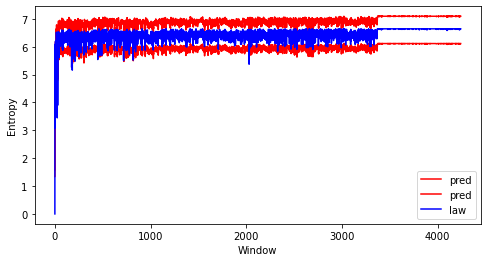

In [39]:

'''
SP_pred_y=SP_lstm.predict(SP_x_valid_r, batch_size=1024)
a=SP_pred_y#[1000:1200]
b=SP_en_valid#[1000:1200]
c=SP_y_valid#[1000:1200]

'''

SP_pred_y=SP_lstm.predict(SP_x_train_r, batch_size=1024)
a=SP_pred_y#[0:600]
b=SP_en_train#[0:600]
c=SP_y_train#[0:600]



b=b.reset_index(drop=True)
c=c.reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.plot(a, label='pred', color='red')
plt.plot(b, label='law',color ='blue')
#plt.plot(c, label='train', color='purple')
plt.xlabel('Window')
plt.ylabel('Entropy')
plt.legend()
plt.show()

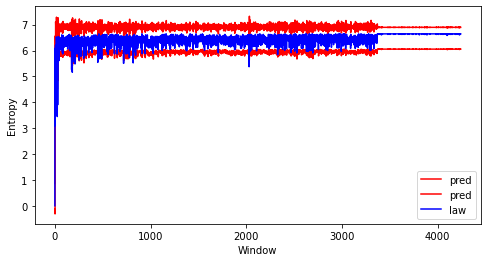

In [40]:


'''
SIP_pred_y=SIP_lstm.predict(SIP_x_valid_r, batch_size=1024)
a=SIP_pred_y#[1000:1200]
b=SIP_en_valid#[1000:1200]
c=SIP_y_valid#[1000:1200]

'''

SIP_pred_y=SIP_lstm.predict(SIP_x_train_r, batch_size=1024)
a=SIP_pred_y#[2000:2200]
b=SIP_en_train#[2000:2200]
c=SIP_y_train#[2000:2200]


b=b.reset_index(drop=True)
c=c.reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.plot(a, label='pred', color='red')
plt.plot(b, label='law',color ='blue')
#plt.plot(c, label='train', color='purple')
plt.xlabel('Window')
plt.ylabel('Entropy')
plt.legend()
plt.show()

In [41]:
DDoS_SIP = pd.read_csv('mer_DDoS_SIP_test.csv')
DDoS_SP = pd.read_csv('mer_DDoS_SP_test.csv')

In [42]:
list1= ['DDoS_SIP','DDoS_SP']
list2=[DDoS_SIP, DDoS_SP]

for n,m in zip(list1, list2):
    globals()['%s_x' % n]=m.iloc[:,1:4] # ex) shift 를 3개 밀면 4로
    globals()['%s_y' % n]=m.iloc[:, [7,8]] #0, 5,6  /1
    globals()['%s_en' % n]=m.iloc[:, [0]] #0
    

    globals()['%s_x_train' % n],globals()['%s_x_valid' % n], globals()['%s_y_train' % n], globals()['%s_y_valid' % n] = train_test_split(globals()['%s_x' % n], globals()['%s_y' % n], train_size = 0.8, shuffle=False)
    globals()['%s_en_train' % n], globals()['%s_en_valid' % n]= train_test_split(globals()['%s_en' % n], train_size = 0.8, shuffle=False)

    globals()['%s_en_train' % n]=globals()['%s_en_train' % n].reset_index(drop=True)
    globals()['%s_en_valid' % n]=globals()['%s_en_valid' % n].reset_index(drop=True)

    globals()['%s_x_train_r' % n] = np.array(globals()['%s_x_train' % n]).reshape((globals()['%s_x_train' % n].shape[0], globals()['%s_x_train' % n].shape[1], 1))
    globals()['%s_y_train_r' % n] = np.array(globals()['%s_y_train' % n]).reshape((globals()['%s_y_train' % n].shape[0], globals()['%s_y_train' % n].shape[1], 1))

    globals()['%s_x_valid_r' % n] = np.array(globals()['%s_x_valid' % n]).reshape((globals()['%s_x_valid' % n].shape[0], globals()['%s_x_valid' % n].shape[1], 1))
    globals()['%s_y_valid_r' % n] = np.array(globals()['%s_y_valid' % n]).reshape((globals()['%s_y_valid' % n].shape[0], globals()['%s_y_valid' % n].shape[1], 1))

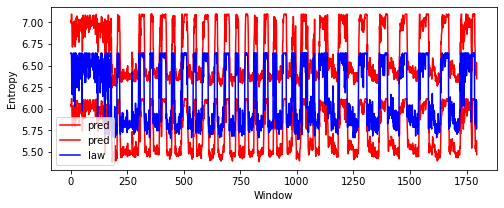

In [46]:
'''
SP_pred_y=SP_lstm.predict(SP_x_valid_r, batch_size=1024)
a=SP_pred_y#[1000:1200]
b=SP_en_valid#[1000:1200]
c=SP_y_valid#[1000:1200]

'''

DDoS_SP_pred_y=SP_lstm.predict(DDoS_SP_x_train_r, batch_size=1024)
a=DDoS_SP_pred_y[10:]
b=DDoS_SP_en_train[10:]



b=b.reset_index(drop=True)

plt.figure(figsize=(8,3))
plt.plot(a, label='pred', color='red')
plt.plot(b, label='law',color ='blue')
plt.xlabel('Window')
plt.ylabel('Entropy')
plt.legend()
plt.show()

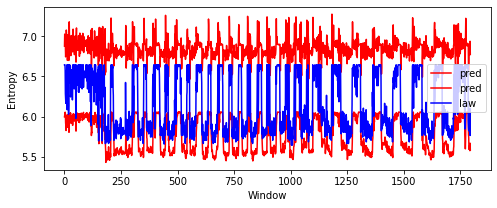

In [45]:
'''
SIP_pred_y=SIP_lstm.predict(SIP_x_valid_r, batch_size=1024)
a=SIP_pred_y#[1000:1200]
b=SIP_en_valid#[1000:1200]
c=SIP_y_valid#[1000:1200]

'''

DDoS_SIP_pred_y=SIP_lstm.predict(DDoS_SIP_x_train_r, batch_size=1024)
a=DDoS_SIP_pred_y[10:]
b=DDoS_SIP_en_train[10:]


b=b.reset_index(drop=True)

plt.figure(figsize=(8,3))
plt.plot(a, label='pred', color='red')
plt.plot(b, label='law',color ='blue')
plt.xlabel('Window')
plt.ylabel('Entropy')
plt.legend()
plt.show()